# **Classification - ob**

In this section, two machine learning models will be used to classify the `ob` column, Random Forest and XGBoost, for both datasets, São Paulo and other states.

The label is 0 if the person is alive and 1 if he / she died.

## **Reading the data**

Reading the data from SP and other states.

We can see that we still have some missing values in both datasets, but the column `DTRECIDIVA` will be dropped, as well the `IDADE` column, because the column `FAIXAETAR` will be used, both have information about the age of the patients. 

The columns `delta_t4`, `delta_t5` and `delta_t6`, can be used as a label in a future analysis, so they will not be as features of the created models.

In [ ]:
df_SP = read_csv('/content/drive/MyDrive/Trabalho/Cancer/Datasets/cancer_SP_labels.csv')
df_fora = read_csv('/content/drive/MyDrive/Trabalho/Cancer/Datasets/cancer_foraSP_labels.csv')

(806402, 94)
(62317, 94)


In [ ]:
# SP
df_SP.isna().sum().sort_values(ascending=False).head(6)

DTRECIDIVA    717377
delta_t6      717377
delta_t5      717377
delta_t4      717377
IDADE              1
TRATAMENTO         0
dtype: int64

In [ ]:
# Other states
df_fora.isna().sum().sort_values(ascending=False).head(6)

DTRECIDIVA    57799
delta_t6      57799
delta_t5      57799
delta_t4      57799
NAOTRAT           0
LOCALTNM          0
dtype: int64

Here we have the correlations between the label and the other columns, the columns with higher correlations will not be used as features of the models, because they may have been used to create the label, such as the ``ULTINFO`` column, or they can be used as label for other machine learning models.

In [ ]:
# SP
corr_matrix = df_SP.corr()
abs(corr_matrix['ob']).sort_values(ascending = False).head(20)

ob              1.000000
vivo_sem_rec    0.946549
ob_sem_rec      0.870247
ULTINFO         0.868236
ano_ob          0.750408
PERDASEG        0.378763
ob_com_rec      0.319736
ANODIAG         0.269601
CIRURGIA        0.249248
QUIMIO          0.244519
delta_t7        0.216269
delta_t8        0.216105
delta_t9        0.212633
CATEATEND       0.212081
RECNENHUM       0.196724
delta_t5        0.169360
delta_t4        0.167767
delta_t6        0.160751
RECREGIO        0.141924
IDADE           0.136383
Name: ob, dtype: float64

In [ ]:
# Other states
corr_matrix = df_fora.corr()
abs(corr_matrix['ob']).sort_values(ascending = False).head(20)

ob              1.000000
vivo_sem_rec    0.949190
ob_sem_rec      0.928200
ULTINFO         0.854305
ano_ob          0.772548
PERDASEG        0.359090
ob_com_rec      0.275720
CIRURGIA        0.257715
QUIMIO          0.253681
ANODIAG         0.252079
CATEATEND       0.209850
delta_t5        0.168003
delta_t8        0.167875
delta_t4        0.166380
delta_t7        0.165922
delta_t9        0.164855
delta_t6        0.163108
RECNENHUM       0.149262
RADIO           0.139862
GLEASON         0.104262
Name: ob, dtype: float64

Here we have the number of examples for each category of the label, it is clear that there is an imbalance. We will need to fix this problem in the preprocessing step and in the models training.

In [ ]:
df_SP.ob.value_counts()

0    480724
1    325678
Name: ob, dtype: int64

In [ ]:
df_fora.ob.value_counts()

0    44591
1    17726
Name: ob, dtype: int64

A curiosity is in the column `PERDASEG`, because when its value is 1, in other words, treatment is not being followed up anymore, the label is always 0 (only one is different), indicating that the patient did not die. For this detail, this column will also not be used as a feature, because the model will be able to adjust many values of the label just using this column.

In [ ]:
df_SP['ob'][df_SP.PERDASEG == 1].value_counts()

0    140925
1         1
Name: ob, dtype: int64

In [ ]:
df_fora['ob'][df_fora.PERDASEG == 1].value_counts()

0    15263
Name: ob, dtype: int64

## **Training and testing split**

Now we are going to divide the data into training and testing, to perform the training of the models and then their evaluation.

First, it is necessary to define the columns that will be used as features and the label. For the features we will not use some columns of the data: `UFRESID`, because we already have the division between SP and other states in the two datasets. The date columns will also be removed, `DTCONSULT, DTDIAG, DTTRAT, DTRECIDIVA, DTULTINFO`, because we already have the difference in days in other columns. 

It was chosen to keep the column `FAIXAETAR`, so we will not use the `IDADE`. Regarding `PERDASEG`, it has already been discussed in the previous section.

The columns `CONSDIAG, TRATCONS, DIAGTRAT` contain the same information as the `delta_t1, delta_t2, delta_t3`. Finally, the other columns contained in the list `list_drop` are possible labels, so they will not be used as features for machine learning models.

In [ ]:
list_drop = ['UFRESID', 'DTCONSULT', 'DTDIAG', 'DTTRAT', 'DTRECIDIVA', 'DTULTINFO',
             'IDADE', 'PERDASEG', 'CONSDIAG', 'TRATCONS', 'DIAGTRAT', 'delta_t4', 
             'delta_t5', 'delta_t6', 'delta_t7', 'delta_t8', 'delta_t9', 'ano_ob',
             'ob_com_rec', 'ob_sem_rec', 'vivo_com_rec', 'vivo_sem_rec', 'ULTINFO']

lb = 'ob'

A function was created to perform the division of the data in training and testing, `get_train_test`. It is only necessary to pass the dataframe that will be used, a list with the columns that will not be used and a string with the name of the column that will be the label.

> To see the complete function go to the [functions section](https://cancer-project.readthedocs.io/en/latest/Cancer%20Libraries%20and%20functions.html#Models).

**SP**

In [ ]:
X_trainSP, X_testSP, y_trainSP, y_testSP = get_train_test(df_SP, list_drop, lb)

X_train = (604801, 70), X_test = (201601, 70)
y_train = (604801,), y_test = (201601,)


**Other states**

In [ ]:
X_trainFora, X_testFora, y_trainFora, y_testFora = get_train_test(df_fora, list_drop, lb)

X_train = (46737, 70), X_test = (15580, 70)
y_train = (46737,), y_test = (15580,)


## **Encoder and normalization**

After dividing the data into training and testing it is necessary to perform the preprocessing in the training data, for this a function was created, `train_preprocessing`, it returns the data encoded (columns that are strings) and normalized. Training data is required for the function.

> See the complete function in the [functions section](https://cancer-project.readthedocs.io/en/latest/Cancer%20Libraries%20and%20functions.html#Models).

**SP**

In [ ]:
X_trainSP_enc, enc_SP, norm_SP = train_preprocessing(X_trainSP, normalizer='StandardScaler')

**Other states**

In [ ]:
X_trainFora_enc, enc_fora, norm_fora = train_preprocessing(X_trainFora, normalizer='StandardScaler')

## **PCA**

Using the PCA, it is possible to reduce the dimensionality of the data, decreasing the number of features. As can be seen from the graphs below, with less features used in the models, smaller will be the representativeness of the total data.

The preprocessing function of the training data already contains this possibility of using the PCA, just use the necessary parameters, see the complete function in the [functions section](https://cancer-project.readthedocs.io/en/latest/Cancer%20Libraries%20and%20functions.html#Models).

**SP**

In [ ]:
pca = PCA()
principalComponents = pca.fit_transform(X_trainSP_enc)

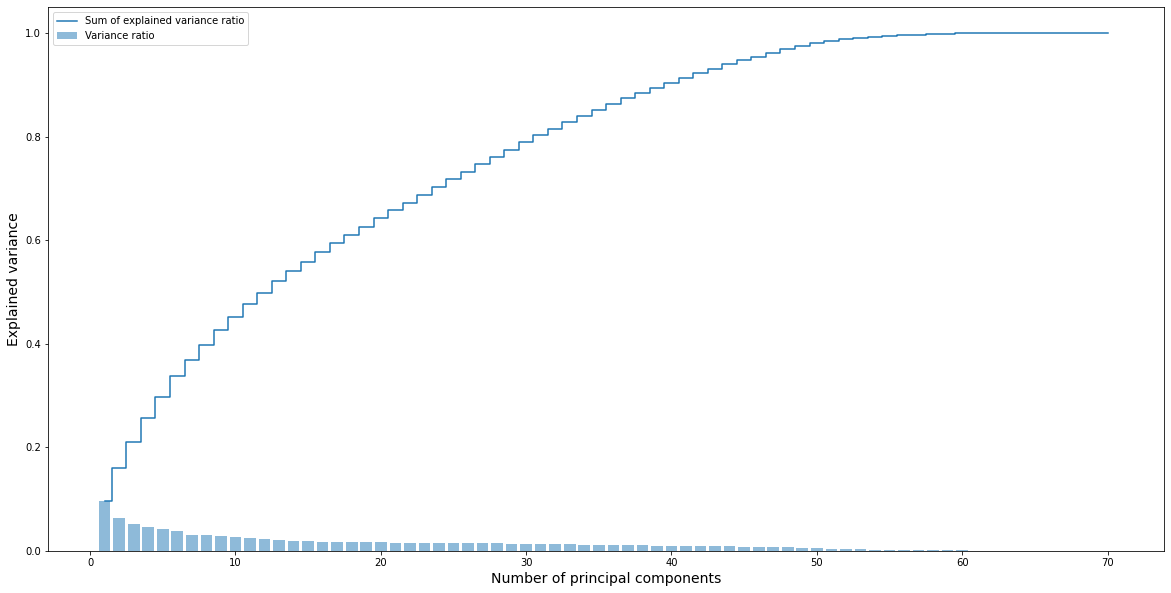

In [ ]:
plt.figure(figsize=(20,10))

plt.bar(np.linspace(1, 70, 70), pca.explained_variance_ratio_, alpha=0.5, 
        align='center', label='Variance ratio')
plt.step(np.linspace(1, 70, 70), np.cumsum(pca.explained_variance_ratio_), where='mid',
         label='Sum of explained variance ratio')

plt.ylabel('Explained variance', size=14)
plt.xlabel('Number of principal components', size=14)
plt.legend()

plt.show()

**Other states**

In [ ]:
pca = PCA()
principalComponents = pca.fit_transform(X_trainFora_enc)

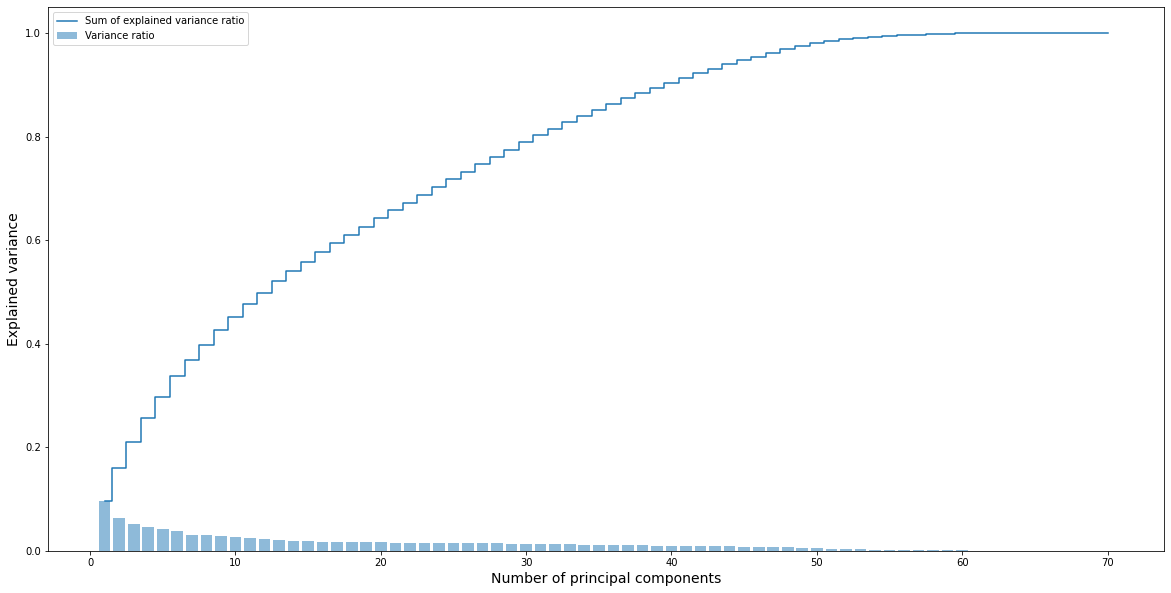

In [ ]:
plt.figure(figsize=(20,10))

plt.bar(np.linspace(1, 70, 70), pca.explained_variance_ratio_, alpha=0.5, 
        align='center', label='Variance ratio')
plt.step(np.linspace(1, 70, 70), np.cumsum(pca.explained_variance_ratio_), where='mid',
         label='Sum of explained variance ratio')

plt.ylabel('Explained variance', size=14)
plt.xlabel('Number of principal components', size=14)
plt.legend()

plt.show()

## **Balancing the data**

As mentioned earlier, we have unbalanced data, more labels with value 0 than with value 1. Therefore, we will use methods to balance the data.

In the case of the SP dataset, an undersampling will be used, which balances the data according to the number of values of the smallest label, in case `ob = 1`. For the dataset with data from other states, the oversampling method will be used, which creates new data for the label with less values (`ob = 1`), after that we have both labels with the same number of examples.

**SP**

In [ ]:
# Number of values for each label in the training data
y_trainSP.value_counts()

0    360572
1    244229
Name: ob, dtype: int64

In [ ]:
rus = RandomUnderSampler(random_state=seed)
X_SP, y_SP = rus.fit_sample(X_trainSP_enc, y_trainSP)

In [ ]:
y_SP.shape

(488458,)

**Other states**

In [ ]:
# Number of values for each label in the training data
y_trainFora.value_counts()

0    33365
1    13372
Name: ob, dtype: int64

In [ ]:
X_fora, y_fora = SMOTE(random_state=seed).fit_resample(X_trainFora_enc, y_trainFora)

In [ ]:
y_fora.shape

(66730,)

## **Training machine learning models**

After dividing the data into training and testing, using the encoder, normalizing the data and balancing, the data is ready to be used by the machine learning models.

### **Random Forest**


The first model that will be tested is the Random Forest, for this test only the `random_state` will be used as a parameter, to obtain the same training values of the model every time it is runned.

In the model for data outside the SP, the hyperparameter `class_weight` was also used, because even after balancing the data the model still has difficulty learning the class with fewer examples, this will be easier to understand when we check the confusion matrix for this model.

In [ ]:
# SP 
rf_sp = RandomForestClassifier(random_state=seed)
rf_sp.fit(X_SP, y_SP)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=10, verbose=0,
                       warm_start=False)

In [ ]:
# Other states
rf_fora = RandomForestClassifier(random_state=seed, class_weight={0: 10, 1: 0.0001})
rf_fora.fit(X_fora, y_fora)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                       class_weight={0: 10, 1: 0.0001}, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=10, verbose=0, warm_start=False)

### **XGBoost**


The training of the XGBoost model follows the same pattern with `random_state`. A higher weight was also used for the class with fewer examples, using the hyperparameter `scale_pos_weight = 10`, for the model with data from outside SP.

The hyperparameter `max_depth` was chosen as 15 because the default value for this hyperparameter is 3, a low value for the amount of data we have.

In [ ]:
# SP
xgboost_sp = xgb.XGBClassifier(max_depth=15, random_state=seed)

xgboost_sp.fit(X_SP, y_SP)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=15,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=10,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [ ]:
# Other states 
xgboost_fora = xgb.XGBClassifier(max_depth=15, scale_pos_weight=10, 
                                 random_state=seed)

xgboost_fora.fit(X_fora, y_fora)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=15,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=10,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=10, seed=None,
              silent=None, subsample=1, verbosity=1)

## **Models evaluation**

After training the models, we will use the confusion matrix to verify the performances, the features importances for each model will also be obtained.

### **Preprocessing of testing data**


The preprocessing of the test data was also done using a function, `test_preprocessing`, passing the test data and the encoder and normalizer, trained to the training data, as parameters.

> See the complete function in the [functions section](https://cancer-project.readthedocs.io/en/latest/Cancer%20Libraries%20and%20functions.html#Models)

In [ ]:
# SP
X_testSP_ = test_preprocessing(X_testSP, enc_SP, norm_SP)

In [ ]:
# Other states
X_testFora_ = test_preprocessing(X_testFora, enc_fora, norm_fora)

### **Random Forest**


Below we have the confusion matrices for the Random Forest models, followed by the graph with the most important features for each model.

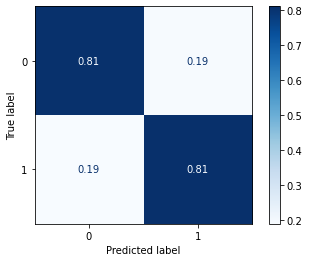

In [ ]:
plot_confusion_matrix(rf_sp, X_testSP_, y_testSP, cmap='Blues', normalize="true", values_format='.2f')
plt.show()

> The confusion matrix obtained for the Random Forest algorithm with the SP data shows a good performance of the model, because the model gets 81% correct for both classes, `ob = 0` and `ob = 1`.

> It is also noticed that the balance of the data worked, because it was not necessary to use a higher weight for the class with fewer examples in the training of the model and we obtained a confusion matrix with the balanced main diagonal.

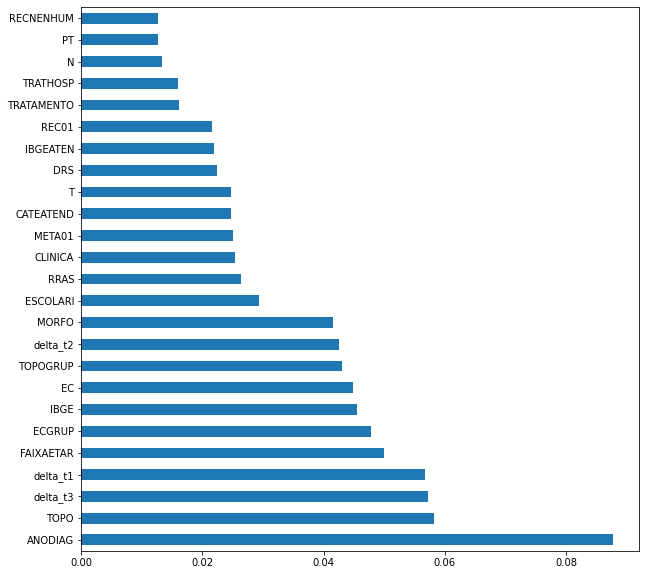

In [ ]:
plot_feat_importances(rf_sp, X_testSP)

> The four most important features in the model were `ANODIAG`, `TOPO`, `delta_t3` and `delta_t1`, the last two being the difference, in days, between treatment and consultation and between diagnosis and consultation, respectively.

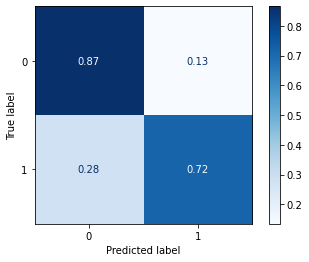

In [ ]:
plot_confusion_matrix(rf_fora, X_testFora_, y_testFora, cmap='Blues', normalize="true", values_format='.2f')
plt.show()

> The confusion matrix obtained for the Random Forest algorithm with the data from another states also shows a good performance of the model, but we have a unbalanced main diagonal in the confusion matrix, it means that we have to adjust the class weights in the model training, in order to obtain a balanced diagonal.


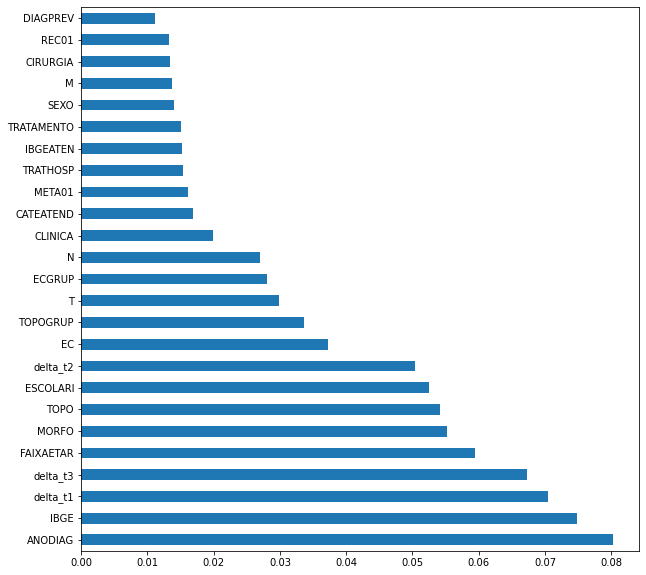

In [ ]:
plot_feat_importances(rf_fora, X_testFora)

> The four most important features in the model were `ANODIAG`, `IBGE`, `delta_t1` and `delta_t3`, the last two being the difference, in days, between diagnosis and consultation and between treatment and consultation, respectively.

### **XGBoost**


Below we have the confusion matrices for the XGBoost models, followed by the graph with the most important features for each model.

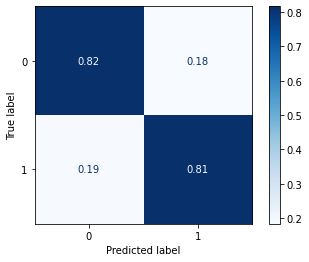

In [ ]:
plot_confusion_matrix(xgboost_sp, X_testSP_, y_testSP, cmap='Blues', normalize='true', values_format='.2f')
plt.show()

> The confusion matrix obtained for the XGBoost algorithm with the SP data shows a good performance of the model, as well as the Random Forest model.

> We also noticed that the balance of the data worked, because it was not necessary to use a higher weight for the class with fewer examples and we obtained a confusion matrix with the balanced main diagonal.

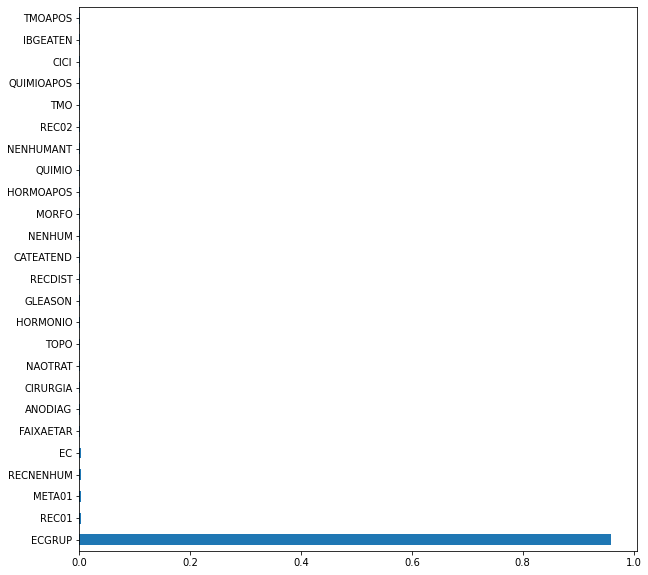

In [ ]:
plot_feat_importances(xgboost_sp, X_testSP)

> Here we noticed that the most used feature was `ECGRUP`, with a lot of advantage over the others.

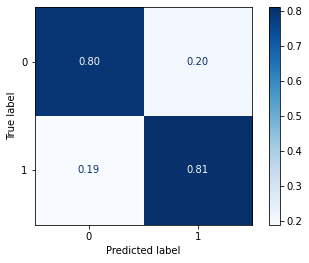

In [ ]:
plot_confusion_matrix(xgboost_fora, X_testFora_, y_testFora, cmap='Blues', normalize="true", values_format='.2f')
plt.show()

> The confusion matrix obtained for the XGBoost algorithm with the data from another states also shows a good performance of the model, as well as the Random Forest model.

> We also obtained a confusion matrix with the balanced main diagonal, with 80% and 81%.

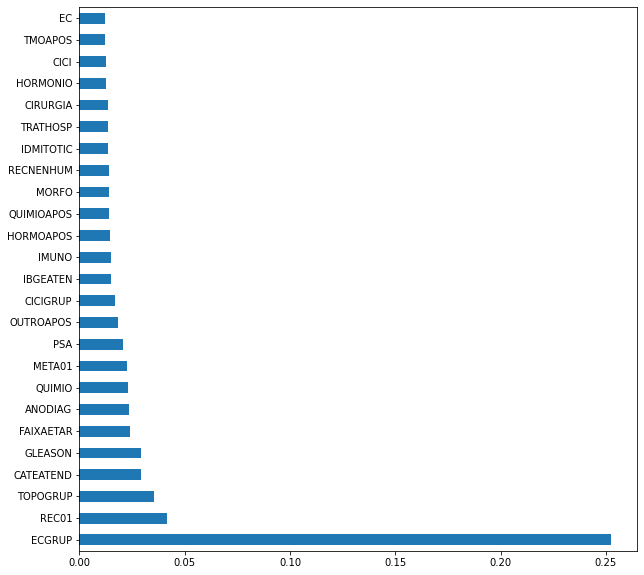

In [ ]:
plot_feat_importances(xgboost_fora, X_testFora)

> Again we noticed that the most used feature was `ECGRUP`, but not with a lot of advantage as seen in the previous analysis. The following most important features were `REC01`, `TOPOGRUP` and `CATEATEND`.

# **Classification - RECNENHUM**

In this section, two machine learning models will be used to classify the `RECNENHUM` column, Random Forest and XGBoost.

The label is 0 if there was a recurrence and 1 if there wasn't.

## **Reading the data**

Reading the data from SP and other states.

We can see that we still have some missing values in both datasets, but the column `DTRECIDIVA` will be dropped, as well the `IDADE` column, because the column `FAIXAETAR` will be used, both have information about the age of the patients. 

The columns `delta_t4`, `delta_t5` and `delta_t6`, can be used as a label in a future analysis, so they will not be as features of the created models.

In [ ]:
df_SP = read_csv('/content/drive/MyDrive/Trabalho/Cancer/Datasets/cancer_SP_labels.csv')
df_fora = read_csv('/content/drive/MyDrive/Trabalho/Cancer/Datasets/cancer_foraSP_labels.csv')

(806402, 94)
(62317, 94)


In [ ]:
# SP
df_SP.isna().sum().sort_values(ascending=False).head(6)

DTRECIDIVA    717377
delta_t6      717377
delta_t5      717377
delta_t4      717377
IDADE              1
TRATAMENTO         0
dtype: int64

In [ ]:
# Other states
df_fora.isna().sum().sort_values(ascending=False).head(6)

DTRECIDIVA    57799
delta_t6      57799
delta_t5      57799
delta_t4      57799
NAOTRAT           0
LOCALTNM          0
dtype: int64

Here we have the correlations between the label and the other columns, the columns with higher correlations will not be used as features of the models, because they may have been used to create the label, such as the ``ULTINFO`` column, or they can be used as label for other machine learning models.

In [ ]:
corr_matrix = df_SP.corr()
abs(corr_matrix['RECNENHUM']).sort_values(ascending = False).head(20)

RECNENHUM       1.000000
ob_com_rec      0.829363
RECLOCAL        0.679652
RECREGIO        0.529338
vivo_com_rec    0.522025
RECDIST         0.497837
vivo_sem_rec    0.364914
ano_ob          0.242833
ob_sem_rec      0.227291
ob              0.196724
QUIMIO          0.147652
RADIO           0.085910
ULTINFO         0.081964
PERDASEG        0.070304
delta_t8        0.064934
delta_t7        0.063559
delta_t9        0.063466
IBGEATEN        0.062526
delta_t5        0.058940
delta_t4        0.055412
Name: RECNENHUM, dtype: float64

In [ ]:
corr_matrix = df_fora.corr()
abs(corr_matrix['RECNENHUM']).sort_values(ascending = False).head(20)

RECNENHUM       1.000000
ob_com_rec      0.749663
RECLOCAL        0.695533
vivo_com_rec    0.642191
RECDIST         0.579667
RECREGIO        0.430531
vivo_sem_rec    0.349104
ano_ob          0.217344
ob              0.149262
ob_sem_rec      0.135709
QUIMIO          0.130924
delta_t8        0.104972
delta_t9        0.103801
delta_t7        0.103667
delta_t5        0.087167
delta_t4        0.082168
delta_t6        0.081259
IDADE           0.074725
RADIO           0.074704
DIAGPREV        0.062018
Name: RECNENHUM, dtype: float64

Here we have the number of examples for each category of the label, it is clear that there is an imbalance, even higher than in the previous classification. We will need to fix this problem in the preprocessing step and in the models training.

In [ ]:
df_SP.RECNENHUM.value_counts()

1    732633
0     73769
Name: RECNENHUM, dtype: int64

In [ ]:
df_fora.RECNENHUM.value_counts()

1    59137
0     3180
Name: RECNENHUM, dtype: int64

## **Training and testing split**

Now we are going to divide the data into training and testing, to perform the training of the models and then their evaluation.

First, 400 thousand examples will be selected from label 1, of more than 700 thousand that we have available, and then this subset will be concatenated with the one containing label 0. Thus, oversampling and training of the models will take less time.

In [ ]:
n_samples = 400000
df_SP_rec = df_SP[df_SP.RECNENHUM == 1].sample(n_samples, random_state=seed).sort_index()
df_SP_sem_rec = df_SP[df_SP.RECNENHUM == 0]
df_SP_menor = pd.concat([df_SP_rec, df_SP_sem_rec]).sort_index()
df_SP_menor.RECNENHUM.value_counts()

1    400000
0     73769
Name: RECNENHUM, dtype: int64

To define the columns that will be used as features and the label, the process will be similar to the one used previously. 

For the features we will not use some columns of the data: `UFRESID`, because we already have the division between SP and other states in the two datasets. The date columns will also be removed, `DTCONSULT, DTDIAG, DTTRAT, DTRECIDIVA, DTULTINFO`, because we already have the difference in days in other columns. 

It was chosen to keep the column `FAIXAETAR`, so we will not use the `IDADE`. Regarding `PERDASEG`, it has already been discussed in the previous section.

The columns `CONSDIAG, TRATCONS, DIAGTRAT` contain the same information as the `delta_t1, delta_t2, delta_t3`. As the label is related to the patients' recurrence, the information related to this will be removed from the features, `RECLOCAL, RECREGIO, RECDIST, REC01, REC02, REC03, REC04`.

Finally, the other columns contained in the list `list_drop` are possible labels, so they will not be used as features for machine learning models.

In [ ]:
list_drop = ['UFRESID', 'DTCONSULT', 'DTDIAG', 'DTTRAT', 'DTRECIDIVA', 'DTULTINFO',
             'IDADE', 'PERDASEG', 'CONSDIAG', 'TRATCONS', 'DIAGTRAT', 'RECLOCAL',
             'RECREGIO', 'RECDIST', 'REC01', 'REC02', 'REC03', 'REC04', 'delta_t4',
             'delta_t5', 'delta_t6', 'delta_t7', 'delta_t8', 'delta_t9', 'ob', 'ano_ob', 
             'ob_com_rec', 'ob_sem_rec', 'vivo_com_rec', 'vivo_sem_rec', 'ULTINFO']

label = 'RECNENHUM'

A function was created to perform the division of the data in training and testing, `get_train_test`. It is only necessary to pass the dataframe that will be used, a list with the columns that will not be used and a string with the name of the column that will be the label.

> To see the complete function go to the [functions section](https://cancer-project.readthedocs.io/en/latest/Cancer%20Libraries%20and%20functions.html#Models).

**SP**

In [ ]:
X_trainSP, X_testSP, y_trainSP, y_testSP = get_train_test(df_SP_menor, list_drop, label)

X_train = (355326, 62), X_test = (118443, 62)
y_train = (355326,), y_test = (118443,)


**Other states**

In [ ]:
X_trainFora, X_testFora, y_trainFora, y_testFora = get_train_test(df_fora, list_drop, label)

X_train = (46737, 62), X_test = (15580, 62)
y_train = (46737,), y_test = (15580,)


## **Encoder and normalization**

After dividing the data into training and testing it is necessary to preprocess the training data, for this a function was created, `train_preprocessing`, it returns the data encoded (columns that are strings) and normalized. Training data is required for the function.

> See the complete function in the [functions section](https://cancer-project.readthedocs.io/en/latest/Cancer%20Libraries%20and%20functions.html#Models).

**SP**

In [ ]:
X_trainSP_enc, enc_SP, norm_SP = train_preprocessing(X_trainSP, normalizer='StandardScaler')

**Other states**

In [ ]:
X_trainFora_enc, enc_fora, norm_fora = train_preprocessing(X_trainFora, normalizer='StandardScaler')

## **PCA**

Using the PCA, it is possible to reduce the dimensionality of the data, decreasing the number of features. As can be seen from the graphs below, with less features used in the models, smaller will be representativeness of the total data.

The preprocessing function of the training data already contains this possibility of using the PCA, just use the necessary parameters, see the complete function in the [functions section](https://cancer-project.readthedocs.io/en/latest/Cancer%20Libraries%20and%20functions.html#Models).

**SP**

In [ ]:
pca = PCA()
principalComponents = pca.fit_transform(X_trainSP_enc)

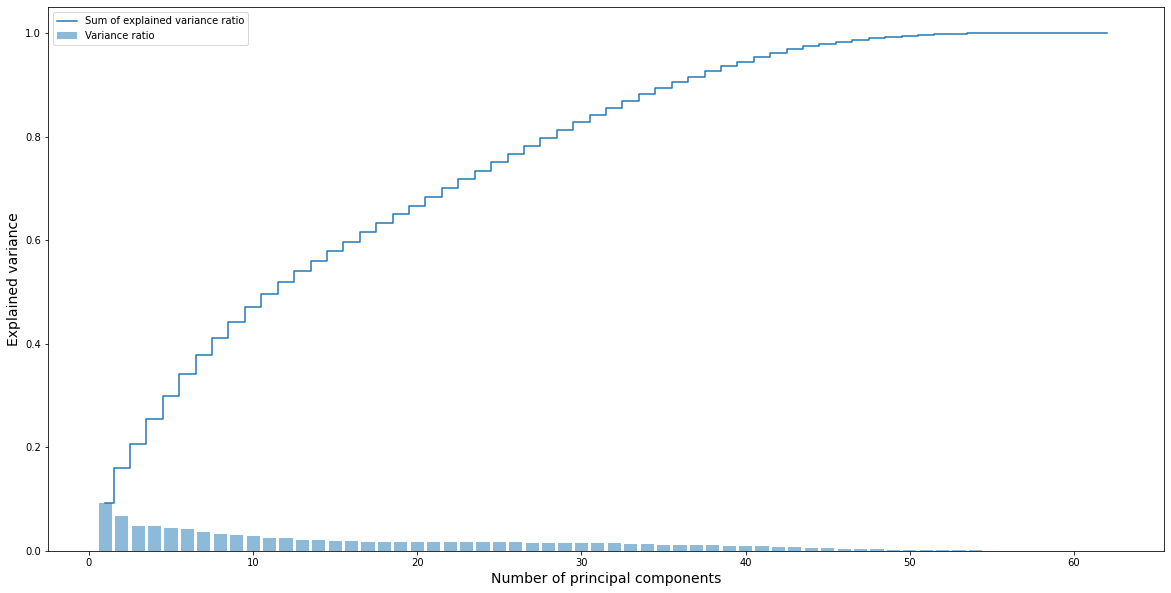

In [ ]:
plt.figure(figsize=(20,10))

plt.bar(np.linspace(1, X_trainSP_enc.shape[1], X_trainSP_enc.shape[1]), 
        pca.explained_variance_ratio_, alpha=0.5, align='center', label='Variance ratio')

plt.step(np.linspace(1, X_trainSP_enc.shape[1], X_trainSP_enc.shape[1]), 
         np.cumsum(pca.explained_variance_ratio_), where='mid',
         label='Sum of explained variance ratio')

plt.ylabel('Explained variance', size=14)
plt.xlabel('Number of principal components', size=14)
plt.legend()

plt.show()

**Other states**

In [ ]:
pca = PCA()
principalComponents = pca.fit_transform(X_trainFora_enc)

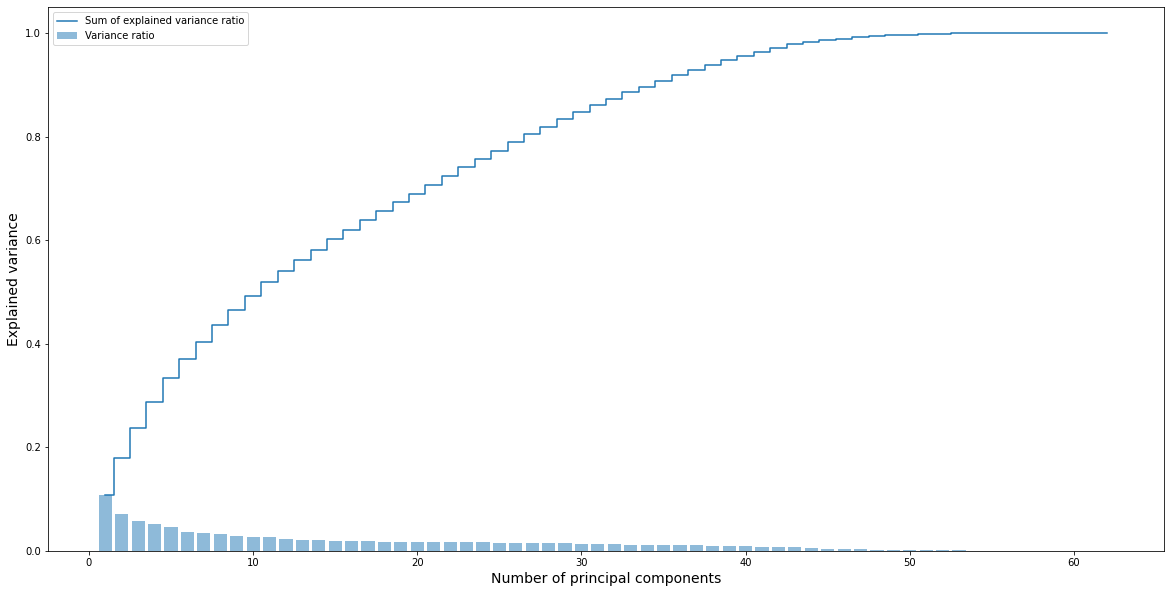

In [ ]:
plt.figure(figsize=(20,10))

plt.bar(np.linspace(1, X_trainFora_enc.shape[1], X_trainFora_enc.shape[1]), 
        pca.explained_variance_ratio_, alpha=0.5, align='center', label='Variance ratio')

plt.step(np.linspace(1, X_trainFora_enc.shape[1], X_trainFora_enc.shape[1]), 
         np.cumsum(pca.explained_variance_ratio_), where='mid',
         label='Sum of explained variance ratio')

plt.ylabel('Explained variance', size=14)
plt.xlabel('Number of principal components', size=14)
plt.legend()

plt.show()

## **Balancing the data**

As mentioned earlier, we have unbalanced data, more labels with value 1 than with value 0. Therefore, we will use methods to balance the data.

In both datasets an oversampling will be used, which creates new data for the label with less values (`RECNENHUM = 0`), after that we have both labels with the same number of examples.

**SP**

In [ ]:
# Number of values for each label in the training data
y_trainSP.value_counts()

1    300057
0     55269
Name: RECNENHUM, dtype: int64

In [ ]:
X_SP, y_SP = SMOTE(random_state=seed).fit_resample(X_trainSP_enc, y_trainSP)

In [ ]:
y_SP.shape

(600114,)

**Other states**

In [ ]:
# Number of values for each label in the training data
y_trainFora.value_counts()

1    44367
0     2370
Name: RECNENHUM, dtype: int64

In [ ]:
X_fora, y_fora = SMOTE(random_state=seed).fit_resample(X_trainFora_enc, y_trainFora)

In [ ]:
y_fora.shape

(88734,)

## **Training machine learning models**

After dividing the data into training and testing, using the encoder, normalizing the data and balancing, the data is ready to be used by the machine learning models.

### **Random Forest**


The first model that will be tested is the Random Forest, for this test the `random_state` and `class_weight` hyperparameters will be used, the first one to obtain the same training values of the model every time it is runned. The `class_weight` was used because even after balancing the data the model still has difficulty to learn the class with fewer examples.

In [ ]:
# SP 
rf_sp = RandomForestClassifier(random_state=seed, 
                               class_weight={0: 19, 1: 0.00006})
rf_sp.fit(X_SP, y_SP)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                       class_weight={0: 19, 1: 6e-05}, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=10, verbose=0, warm_start=False)

In [ ]:
# Other states
rf_fora = RandomForestClassifier(random_state=seed, 
                                 class_weight={0: 24, 1: 0.000022})
rf_fora.fit(X_fora, y_fora)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                       class_weight={0: 24, 1: 2.2e-05}, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=10, verbose=0, warm_start=False)

### **XGBoost**


The training of the XGBoost model follows the same pattern with `random_state`. A smaller weight was also used for the class with fewer examples, using the hyperparameter `scale_pos_weight`, for both models.

The hyperparameter `max_depth` was chosen as 15 because the default value for this hyperparameter is 3, a low value for the amount of data we have.

In [ ]:
# SP
xgboost_sp = xgb.XGBClassifier(max_depth=15,
                               scale_pos_weight=0.15,
                               random_state=seed)

xgboost_sp.fit(X_SP, y_SP)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=15,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=10,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=0.15, seed=None,
              silent=None, subsample=1, verbosity=1)

In [ ]:
# Other states
xgboost_fora = xgb.XGBClassifier(max_depth=15,
                                 scale_pos_weight=0.02, # 0.05 - 0.01
                                 random_state=seed)

xgboost_fora.fit(X_fora, y_fora)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=15,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=10,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=0.02, seed=None,
              silent=None, subsample=1, verbosity=1)

## **Models evaluation**

After training the models, we will use the confusion matrix to verify the performances, the features importances for each model will also be obtained.

### **Preprocessing of testing data**


The preprocessing of the test data was also done using a function, `test_preprocessing`, passing the test data and the encoder and normalizer, trained to the training data, as parameters.

> See the complete function in the [functions section](https://cancer-project.readthedocs.io/en/latest/Cancer%20Libraries%20and%20functions.html#Models)

In [ ]:
# SP
X_testSP_ = test_preprocessing(X_testSP, enc_SP, norm_SP)

In [ ]:
# Other states
X_testFora_ = test_preprocessing(X_testFora, enc_fora, norm_fora)

### **Random Forest**


Below we have the confusion matrices for the Random Forest models, followed by the graph with the most important features for each model.

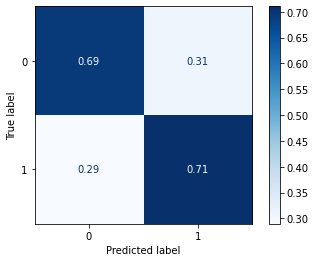

In [ ]:
plot_confusion_matrix(rf_sp, X_testSP_, y_testSP, cmap='Blues', normalize="true", values_format='.2f')
plt.show()

> The confusion matrix obtained for the Random Forest algorithm with the SP data shows a good performance of the model, because we obtained a confusion matrix with the balanced main diagonal.

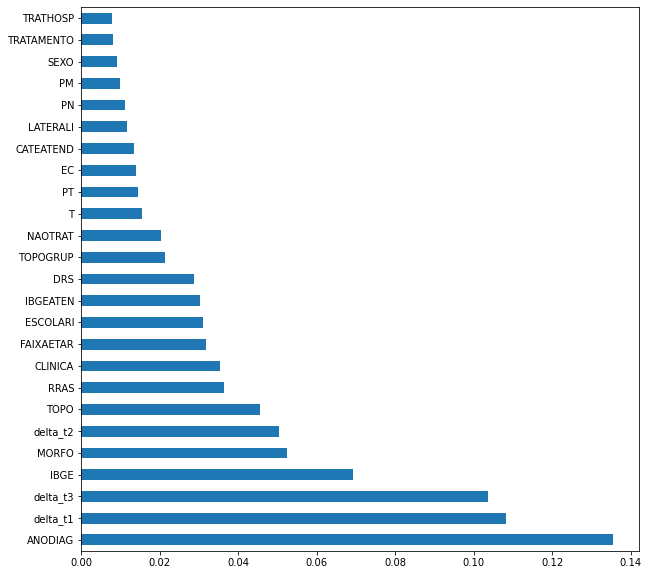

In [ ]:
plot_feat_importances(rf_sp, X_testSP)

> The four most important features in the model were `ANODIAG`, `delta_t1`, `delta_t3` and `IBGE`. `delta_t1` is the difference, in days, between diagnosis and consultation and `delta_t3` is the differnce between treatment and consultation.

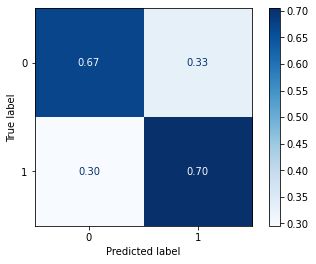

In [ ]:
plot_confusion_matrix(rf_fora, X_testFora_, y_testFora, cmap='Blues', normalize="true", values_format='.2f')
plt.show()

> The confusion matrix obtained for the Random Forest algorithm with the data from another states also shows a good performance of the model, we have a more balanced main diagonal in the confusion matrix, with almost 70% of accuracy for both classes.

> The performance was worse in relation to the first classifiers because we removed more features in this case, representing a loss in the accuracy of the models.


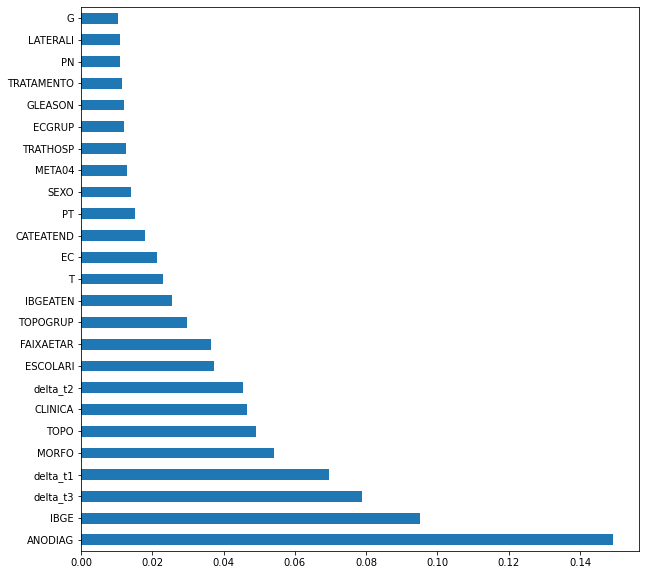

In [ ]:
plot_feat_importances(rf_fora, X_testFora)

> The four most important features in the model were `ANODIAG`, `IBGE`, `delta_t3` and `delta_t1`, the last two being the difference, in days, between  treatment and consultation and between diagnosis and consultation, respectively.

### **XGBoost**


Below we have the confusion matrices for the XGBoost models, followed by the graph with the most important features for each model.

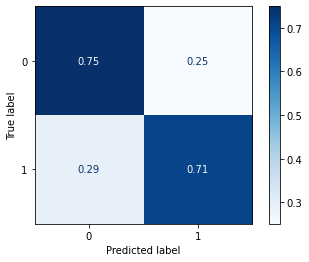

In [ ]:
plot_confusion_matrix(xgboost_sp, X_testSP_, y_testSP, cmap='Blues', normalize="true", values_format='.2f')
plt.show()

> The confusion matrix obtained for the XGBoost algorithm with the SP data shows a good performance of the model, even better than the Random Forest model.

> We also obtained a confusion matrix with the balanced main diagonal, it is possible to refine the class weight to obtain a better balance.

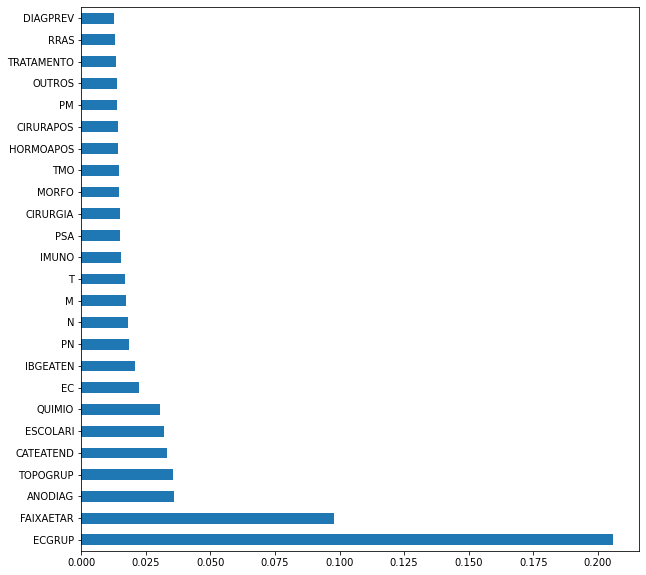

In [ ]:
plot_feat_importances(xgboost_sp, X_testSP)

> Again we noticed that the most used feature was `ECGRUP`, but not with a lot of advantage as seen in the previous analysis. The following most important features were `FAIXAETAR`, `ANODIAG` and `TOPOGRUP`.

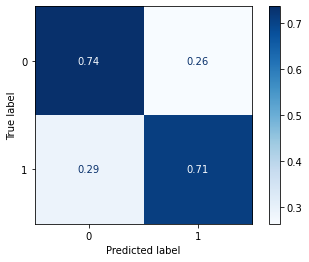

In [ ]:
plot_confusion_matrix(xgboost_fora, X_testFora_, y_testFora, cmap='Blues', normalize="true", values_format='.2f')
plt.show() 

> The confusion matrix obtained for the XGBoost algorithm with the data from another states also shows a good performance of the model, even better than the Random Forest model too. It is possible to refine the class weight to obtain a better balance in the main diagonal.

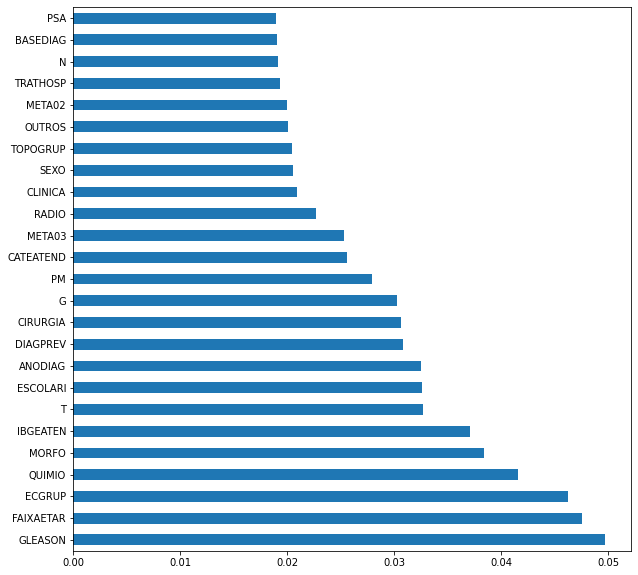

In [ ]:
plot_feat_importances(xgboost_fora, X_testFora)

> The four most important features in the model were `GLEASON`, `FAIXAETAR`, `ECGRUP`, and `QUIMIO`.

# **Classification - RECDIST**

In this section, two machine learning models will be used to classify the `RECDIST` column, Random Forest and XGBoost.

The label is 0 if there was no distant recurrence and 1 if there was.

## **Reading the data**

Reading the data from SP and other states.

We can see that we still have some missing values in both datasets, but the column `DTRECIDIVA` will be dropped, as well the `IDADE` column, because the column `FAIXAETAR` will be used, both have information about the age of the patients. 

The columns `delta_t4`, `delta_t5` and `delta_t6`, can be used as a label in a future analysis, so they will not be as features of the created models.

In [ ]:
df_SP = read_csv('/content/drive/MyDrive/Trabalho/Cancer/Datasets/cancer_SP_labels.csv')
df_fora = read_csv('/content/drive/MyDrive/Trabalho/Cancer/Datasets/cancer_foraSP_labels.csv')

(806402, 94)
(62317, 94)


In [ ]:
df_SP.isna().sum().sort_values(ascending=False).head(6)

DTRECIDIVA    717377
delta_t6      717377
delta_t5      717377
delta_t4      717377
IDADE              1
TRATAMENTO         0
dtype: int64

In [ ]:
df_fora.isna().sum().sort_values(ascending=False).head(6)

DTRECIDIVA    57799
delta_t6      57799
delta_t5      57799
delta_t4      57799
NAOTRAT           0
LOCALTNM          0
dtype: int64

Here we have the correlations between the label and the other columns, the columns with higher correlations will not be used as features of the models, because they may have been used to create the label, such as the ``ULTINFO`` column, or they can be used as label for other machine learning models.

In [ ]:
corr_matrix = df_SP.corr()
abs(corr_matrix['RECDIST']).sort_values(ascending = False).head(20)

RECDIST         1.000000
RECNENHUM       0.497837
ob_com_rec      0.427203
vivo_com_rec    0.238029
vivo_sem_rec    0.181668
ano_ob          0.119045
ob_sem_rec      0.113154
QUIMIO          0.109437
ob              0.105117
CATEATEND       0.093630
ANODIAG         0.084918
LATERALI        0.081624
RECLOCAL        0.058266
PERDASEG        0.055281
HORMONIO        0.045904
RRAS            0.043732
IBGEATEN        0.043044
RADIO           0.041206
delta_t5        0.040047
RADIOAPOS       0.038809
Name: RECDIST, dtype: float64

In [ ]:
corr_matrix = df_fora.corr()
abs(corr_matrix['RECDIST']).sort_values(ascending = False).head(20)

RECDIST         1.000000
RECNENHUM       0.579667
ob_com_rec      0.459205
vivo_com_rec    0.343707
vivo_sem_rec    0.202364
ano_ob          0.120521
QUIMIO          0.107406
ob              0.095742
CATEATEND       0.087712
ob_sem_rec      0.078666
LATERALI        0.073880
DIAGPREV        0.071119
ANODIAG         0.067613
RADIO           0.062403
RECLOCAL        0.050995
PERDASEG        0.047730
HORMONIO        0.046865
delta_t5        0.030107
DIAGTRAT        0.027065
delta_t2        0.027065
Name: RECDIST, dtype: float64

Here we have the number of examples for each category of the label, it is clear that there is an imbalance, similar to the previous classification. We will need to fix this problem in the preprocessing step and in the models training.

In [ ]:
df_SP.RECDIST.value_counts()

0    786768
1     19634
Name: RECDIST, dtype: int64

In [ ]:
df_fora.RECDIST.value_counts()

0    61211
1     1106
Name: RECDIST, dtype: int64

## **Training and testing split**

Now we are going to divide the data into training and testing, to perform the training of the models and then their evaluation.

First, as we did in the last classification, 400 thousand examples will be selected from label 0, of almost 800 thousand that we have available, and then this subset will be concatenated with the one containing label 1. Thus, oversampling and training of the models will take less time.

In [ ]:
n_samples = 400000
df_SP_sem_rec = df_SP[df_SP.RECDIST == 0].sample(n_samples, random_state=seed).sort_index()
df_SP_rec = df_SP[df_SP.RECDIST == 1]
df_SP_menor = pd.concat([df_SP_rec, df_SP_sem_rec]).sort_index()
df_SP_menor.RECDIST.value_counts()

0    400000
1     19634
Name: RECDIST, dtype: int64

To define the columns that will be used as features and the label, the process will be similar to the one used previously. 

For the features we will not use some columns of the data: `UFRESID`, because we already have the division between SP and other states in the two datasets. The date columns will also be removed, `DTCONSULT, DTDIAG, DTTRAT, DTRECIDIVA, DTULTINFO`, because we already have the difference in days in other columns. 

It was chosen to keep the column `FAIXAETAR`, so we will not use the `IDADE`. Regarding `PERDASEG`, it has already been discussed in the previous section.

The columns `CONSDIAG, TRATCONS, DIAGTRAT` contain the same information as the `delta_t1, delta_t2, delta_t3`. As the label is related to the patients' recurrence, the information related to this will be removed from the features, `RECNENHUM, RECLOCAL, RECREGIO, REC01, REC02, REC03, REC04`.

Finally, the other columns contained in the list `list_drop` are possible labels, so they will not be used as features for machine learning models.

In [ ]:
list_drop = ['UFRESID', 'DTCONSULT', 'DTDIAG', 'DTTRAT', 'DTRECIDIVA', 'DTULTINFO',
             'IDADE', 'PERDASEG', 'CONSDIAG', 'TRATCONS', 'DIAGTRAT', 'RECNENHUM',
             'RECLOCAL', 'RECREGIO', 'REC01', 'REC02', 'REC03', 'REC04', 'delta_t4',
             'delta_t5', 'delta_t6', 'delta_t7', 'delta_t8', 'delta_t9', 'ob', 'ano_ob', 
             'ob_com_rec', 'ob_sem_rec', 'vivo_com_rec', 'vivo_sem_rec', 'ULTINFO']

lb = 'RECDIST'

A function was created to perform the division of the data in training and testing, `get_train_test`. It is only necessary to pass the dataframe that will be used, a list with the columns that will not be used and a string with the name of the column that will be the label.

> To see the complete function go to the [functions section](https://cancer-project.readthedocs.io/en/latest/Cancer%20Libraries%20and%20functions.html#Models).

**SP**

In [ ]:
X_trainSP, X_testSP, y_trainSP, y_testSP = get_train_test(df_SP_menor, list_drop, lb)

X_train = (314725, 62), X_test = (104909, 62)
y_train = (314725,), y_test = (104909,)


**Other states**

In [ ]:
X_trainFora, X_testFora, y_trainFora, y_testFora = get_train_test(df_fora, list_drop, lb)

X_train = (46737, 62), X_test = (15580, 62)
y_train = (46737,), y_test = (15580,)


## **Encoder and normalization**

After dividing the data into training and testing it is necessary to preprocess the training data, for this a function was created, `train_preprocessing`, it returns the data encoded (columns that are strings) and normalized. Training data is required for the function.

> See the complete function in the [functions section](https://cancer-project.readthedocs.io/en/latest/Cancer%20Libraries%20and%20functions.html#Models).

**SP**

In [ ]:
X_trainSP_enc, enc_SP, norm_SP = train_preprocessing(X_trainSP, normalizer='StandardScaler')

**Other states**

In [ ]:
X_trainFora_enc, enc_fora, norm_fora = train_preprocessing(X_trainFora, normalizer='StandardScaler')

## **PCA**

Using the PCA, it is possible to reduce the dimensionality of the data, decreasing the number of features. As can be seen from the graphs below, with less features used in the models, smaller will be representativeness of the total data.

The preprocessing function of the training data already contains this possibility of using the PCA, just use the necessary parameters, see the complete function in the [functions section](https://cancer-project.readthedocs.io/en/latest/Cancer%20Libraries%20and%20functions.html#Models).

**SP**

In [ ]:
pca = PCA()
principalComponents = pca.fit_transform(X_trainSP_enc)

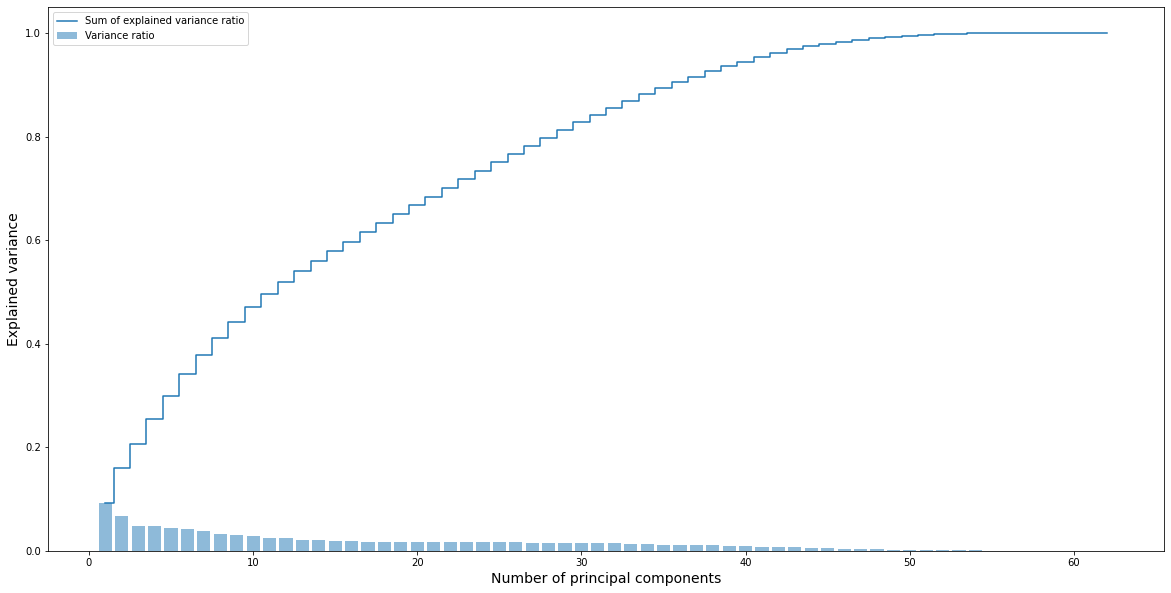

In [ ]:
plt.figure(figsize=(20,10))

plt.bar(np.linspace(1, X_trainSP_enc.shape[1], X_trainSP_enc.shape[1]), 
        pca.explained_variance_ratio_, alpha=0.5, align='center', label='Variance ratio')

plt.step(np.linspace(1, X_trainSP_enc.shape[1], X_trainSP_enc.shape[1]), 
         np.cumsum(pca.explained_variance_ratio_), where='mid',
         label='Sum of explained variance ratio')

plt.ylabel('Explained variance', size=14)
plt.xlabel('Number of principal components', size=14)
plt.legend()

plt.show()

**Other states**

In [ ]:
pca = PCA()
principalComponents = pca.fit_transform(X_trainFora_enc)

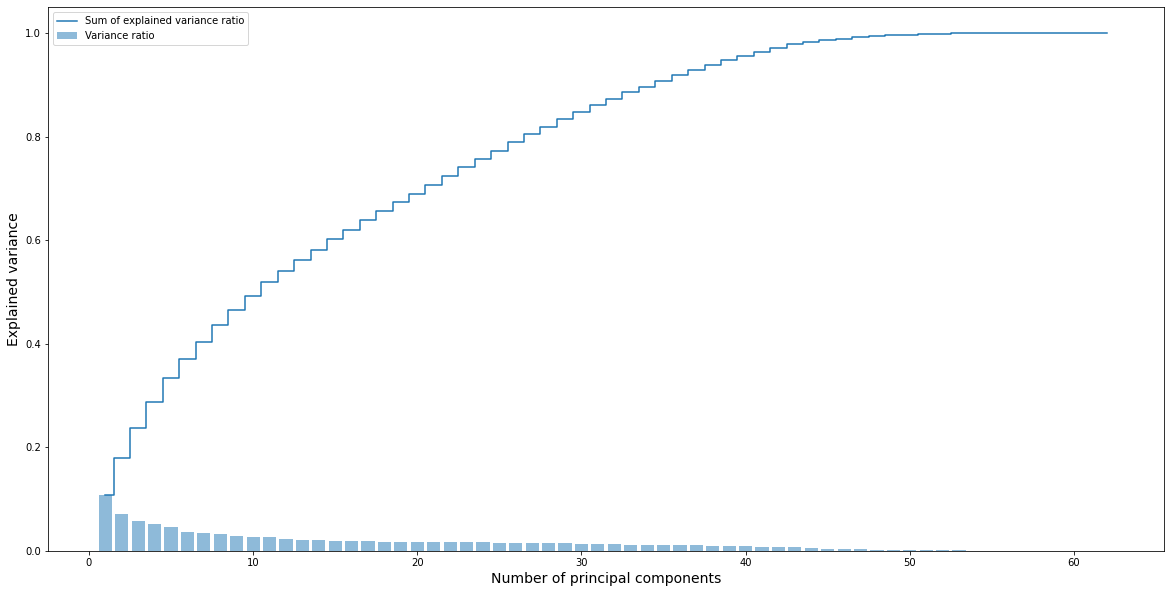

In [ ]:
plt.figure(figsize=(20,10))

plt.bar(np.linspace(1, X_trainFora_enc.shape[1], X_trainFora_enc.shape[1]), 
        pca.explained_variance_ratio_, alpha=0.5, align='center', label='Variance ratio')

plt.step(np.linspace(1, X_trainFora_enc.shape[1], X_trainFora_enc.shape[1]), 
         np.cumsum(pca.explained_variance_ratio_), where='mid',
         label='Sum of explained variance ratio')

plt.ylabel('Explained variance', size=14)
plt.xlabel('Number of principal components', size=14)
plt.legend()

plt.show()

## **Balancing the data**

As mentioned earlier, we have unbalanced data, more labels with value 0 than in relation with value 1. Therefore, we will use methods to balance the data.

In both datasets an oversampling will be used, which creates new data for the label with less values (`RECDIST = 1`), after that we have both labels with the same number of examples.

**SP**

In [ ]:
# Number of values for each label in the training data
y_trainSP.value_counts()

0    300054
1     14671
Name: RECDIST, dtype: int64

In [ ]:
X_SP, y_SP = SMOTE(random_state=seed).fit_resample(X_trainSP_enc, y_trainSP)

In [ ]:
y_SP.shape

(600108,)

**Other states**

In [ ]:
# Number of values for each label in the training data
y_trainFora.value_counts()

0    45898
1      839
Name: RECDIST, dtype: int64

In [ ]:
X_fora, y_fora = SMOTE(random_state=seed).fit_resample(X_trainFora_enc, y_trainFora)

In [ ]:
y_fora.shape

(91796,)

## **Training machine learning models**

After dividing the data into training and testing, using the encoder, normalizing the data and balancing, the data is ready to be used by the machine learning models.

### **Random Forest**


The first model that will be tested is the Random Forest, for this test the `random_state` and `class_weight` hyperparameters will be used, the first one to obtain the same training values of the model every time it is runned. The `class_weight` was used because even after balancing the data the model still has difficulty to learn the class with fewer examples.



In [ ]:
# SP 
rf_sp = RandomForestClassifier(random_state=seed, class_weight={0: 0.00003, 1: 18})
rf_sp.fit(X_SP, y_SP)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                       class_weight={0: 3e-05, 1: 18}, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=10, verbose=0, warm_start=False)

In [ ]:
# Other states
rf_fora = RandomForestClassifier(random_state=seed, class_weight={0: 0.00001, 1: 24}) 
rf_fora.fit(X_fora, y_fora)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                       class_weight={0: 1e-05, 1: 24}, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=10, verbose=0, warm_start=False)

### **XGBoost**


The training of the XGBoost model follows the same pattern with `random_state`. A higher weight was also used for the class with fewer examples, using the hyperparameter `scale_pos_weight`, for both models.

The hyperparameter `max_depth` was chosen as 15 because the default value for this hyperparameter is 3, a low value for the amount of data we have.

In [ ]:
# SP
xgboost_sp = xgb.XGBClassifier(max_depth=15,
                               scale_pos_weight=10_000,
                               random_state=seed)

xgboost_sp.fit(X_SP, y_SP)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=15,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=10,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=10000, seed=None,
              silent=None, subsample=1, verbosity=1)

In [ ]:
# Other states
xgboost_fora = xgb.XGBClassifier(max_depth=15,
                                 scale_pos_weight=300_000,
                                 random_state=seed)

xgboost_fora.fit(X_fora, y_fora)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=15,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=10,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=300000, seed=None,
              silent=None, subsample=1, verbosity=1)

## **Models evaluation**

After training the models, we will use the confusion matrix to verify the performances, the features importances for each model will also be obtained.

### **Preprocessing of testing data**


The preprocessing of the test data was also done using a function, `test_preprocessing`, passing the test data and the encoder and normalizer, trained to the training data, as parameters.

> See the complete function in the [functions section](https://cancer-project.readthedocs.io/en/latest/Cancer%20Libraries%20and%20functions.html#Models)

In [ ]:
# SP
X_testSP_ = test_preprocessing(X_testSP, enc_SP, norm_SP)

In [ ]:
# Other states
X_testFora_ = test_preprocessing(X_testFora, enc_fora, norm_fora)

### **Random Forest**


Below we have the confusion matrices for the Random Forest models, followed by the graph with the most important features for each model.

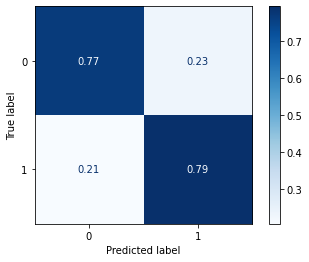

In [ ]:
plot_confusion_matrix(rf_sp, X_testSP_, y_testSP, cmap='Blues', normalize="true", values_format='.2f')
plt.show()

> The confusion matrix obtained for the Random Forest algorithm with the SP data shows a good performance of the model, because we obtained a balanced main diagonal, with 78% of accuracy.

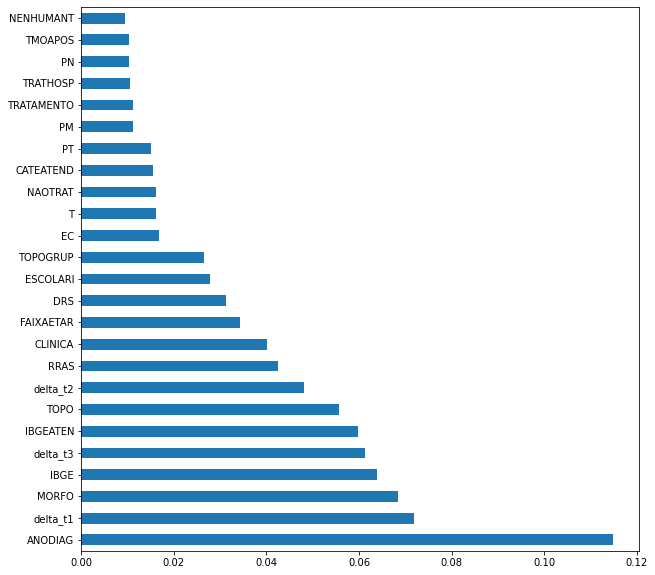

In [ ]:
plot_feat_importances(rf_sp, X_testSP)

> The four most important features in the model were `ANODIAG`, `delta_t1`, `MORFO` and `IBGE`. `delta_t1` is the difference, in days, between diagnosis and consultation.

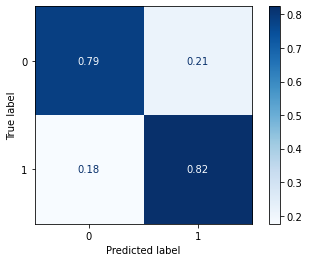

In [ ]:
plot_confusion_matrix(rf_fora, X_testFora_, y_testFora, cmap='Blues', normalize="true", values_format='.2f')
plt.show()

> The confusion matrix obtained for the Random Forest algorithm with the data from another states also shows a good performance of the model, we have a more balanced main diagonal in the confusion matrix, with 80% of accuracy for both classes.


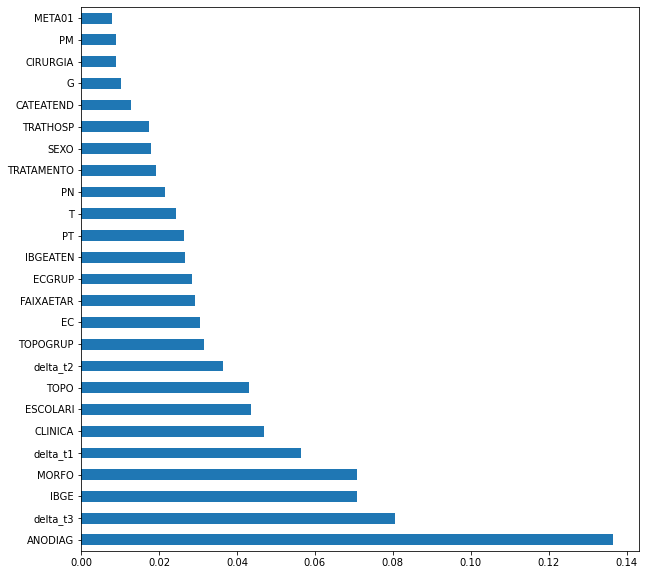

In [ ]:
plot_feat_importances(rf_fora, X_testFora)

> The four most important features in the model were `ANODIAG`, `delta_t3`, `IBGE` and `MORFO`. `delta_t3` is the differnce between treatment and consultation.

### **XGBoost**


Below we have the confusion matrices for the XGBoost models, followed by the graph with the most important features for each model.

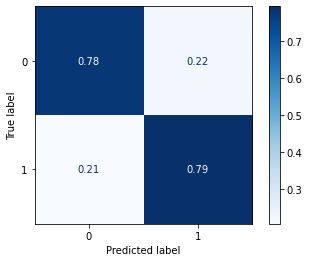

In [ ]:
plot_confusion_matrix(xgboost_sp, X_testSP_, y_testSP, cmap='Blues', normalize="true", values_format='.2f')
plt.show()

> The confusion matrix obtained for the XGBoost algorithm with the SP data shows a good performance of the model, similar to the Random Forest model.

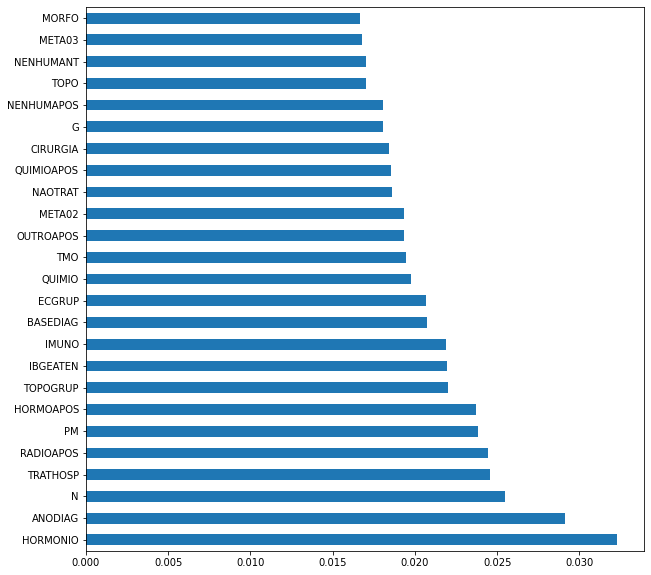

In [ ]:
plot_feat_importances(xgboost_sp, X_testSP)

> The four most important features in the model were `HORMONIO`, `ANODIAG`, `N` and `TRATHOSP`.

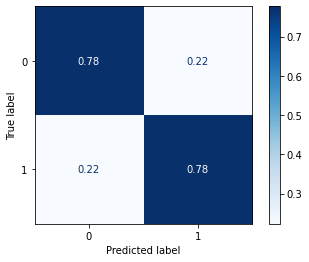

In [ ]:
plot_confusion_matrix(xgboost_fora, X_testFora_, y_testFora, cmap='Blues', normalize="true", values_format='.2f')
plt.show() 

> The confusion matrix obtained for the XGBoost algorithm with the data from another states also shows a good performance of the model, with 78% of accuracy. 

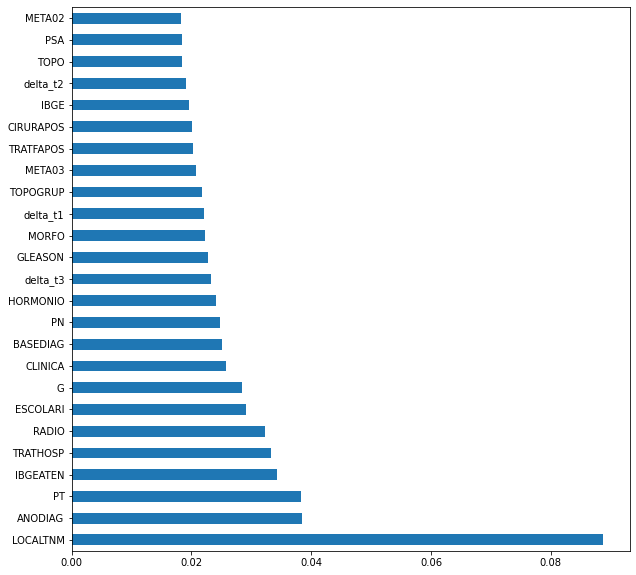

In [ ]:
plot_feat_importances(xgboost_fora, X_testFora)

> The four most important features in the model were `LOCALTNM`, `ANODIAG`, `PT` and `IBGEATEN`.